In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from scipy import interpolate

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import numpy as np

import lsst.daf.persistence as daf_persistence

In [2]:
repo_version = 'test6_new'
repo_base = "/Users/sullivan/LSST/simulations/" + repo_version + "/"

base_range = np.append(np.arange(0, 23, 2), np.arange(1, 23, 2))
zenith_angle_falling = np.arange(30, 90, 5)
zenith_angle_rising = np.arange(30, 90, 5)

In [3]:
def diasrc_metric(repository=".", repository_src=None, obsid_range=None, band='g'):
    """
    Compute statistics on diaSrc tables and return the results.
    @param repository: path to repository with the data. String, defaults to working directory
    @param obsid_range: obsid or range of obsids to process.
    """
    
    saturation = 65000.0
    butler = daf_persistence.Butler(repository)
    if repository_src is not None:
        butler2 = daf_persistence.Butler(repository_src)

    if hasattr(obsid_range, '__iter__'):
        if len(obsid_range) > 2:
            if obsid_range[2] < obsid_range[0]:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in np.arange(obsid_range[0], obsid_range[1], obsid_range[2]))
            else:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in obsid_range)
        else:
            dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                      for obsid in np.arange(obsid_range[0], obsid_range[1]))
    else:
        dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band} for obsid in [obsid_range])

    schema = None
    for _id in dataId:
        dia_src = butler.get("deepDiff_diaSrc", dataId=_id)
        if dia_src.isContiguous() is False:
            dia_src = dia_src.copy(True)
        if schema is None:
            schema = dia_src.getSchema()
            # dipoleKey = schema.find("ip_diffim_DipoleFit_flag_classification").key
            posFluxKey = schema.find("ip_diffim_PsfDipoleFlux_pos_flux").key
            negFluxKey = schema.find("ip_diffim_PsfDipoleFlux_neg_flux").key
            fluxKey = schema.find("base_PsfFlux_flux").key
            sigmaKey = schema.find("base_PsfFlux_fluxSigma").key
            flagKey = schema.find("base_PsfFlux_flag").key
            # flag2Key = schema.find("base_PixelFlags_flag_saturated").key
            # orientationKey = schema.find("ip_diffim_DipoleFit_orientation").key
            # separationKey = schema.find("ip_diffim_DipoleFit_separation").key

        if repository_src is not None:
            ref_src = butler2.get("src", dataId=_id)
            if ref_src.isContiguous() is False:
                ref_src = ref_src.copy(True)
            schema2 = ref_src.getSchema()
            sigmaKey2 = schema2.find("base_PsfFlux_fluxSigma").key
            fluxKey2 = schema2.find("base_PsfFlux_flux").key
            flagKey2 = schema2.find("base_PsfFlux_flag").key
        else:
            ref_src = dia_src
            sigmaKey2 = sigmaKey
            fluxKey2 = fluxKey
            flagKey2 = flagKey

        flux_ref = np.abs(ref_src[fluxKey2])
        flux_ref = flux_ref[~ref_src[flagKey2]]
        flux_ref = np.clip(flux_ref, 1.0, saturation)
        flux_ref = np.sum(flux_ref[np.isfinite(flux_ref)])

        combined_flux = (np.abs(dia_src[posFluxKey]) + np.abs(dia_src[negFluxKey]))
        metric = np.clip(combined_flux, 1.0, saturation) / np.abs(dia_src[sigmaKey])
        metric = metric[~dia_src[flagKey]]
        metric = np.log(1.0 + np.sum(metric[np.isfinite(metric)]) / np.sqrt(flux_ref))
        yield (_id['visit'], _id['filter'], metric)

In [4]:
repo = repo_base + "Diffim_dcr"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 24, 2), np.arange(1, 24, 2))
metric_gen = diasrc_metric(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_dcr_rising = []
metric_dcr_rising = []
obs_dcr_falling = []
metric_dcr_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_dcr_rising.append(metric[0])
        metric_dcr_rising.append(metric[2])
    else:
        obs_dcr_falling.append(metric[0])
        metric_dcr_falling.append(metric[2])

(100, 'g', 0.12572883827980416)
(102, 'g', 0.023291261009799644)
(104, 'g', 0.076633933617117025)
(106, 'g', 0.025644864670339551)
(108, 'g', 0.019250656458872969)
(110, 'g', 0.021169507965084367)
(112, 'g', 0.06105374067683849)
(114, 'g', 0.025993162890226948)
(116, 'g', 0.092254891372790915)
(118, 'g', 0.082611136557092346)
(120, 'g', 0.15173253960599647)
(122, 'g', 0.058054470905665422)
(101, 'g', 0.17016012337019717)
(103, 'g', 0.085827076634689692)
(105, 'g', 0.0528153663998868)
(107, 'g', 0.069140539650547131)
(109, 'g', 0.06290382878248281)
(111, 'g', 0.029565424993766343)
(113, 'g', 0.025414564311876223)
(115, 'g', 0.16363252648980461)
(117, 'g', 0.081576923243335084)
(119, 'g', 0.057567788307378902)
(121, 'g', 0.062775802068402817)
(123, 'g', 0.0066834778309100814)


In [6]:
repo = repo_base + "Diffim_5deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_5deg_rising = []
metric_5deg_rising = []
obs_5deg_falling = []
metric_5deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_5deg_rising.append(metric[0])
        metric_5deg_rising.append(metric[2])
    else:
        obs_5deg_falling.append(metric[0])
        metric_5deg_falling.append(metric[2])

(100, 'g', 1.0237787854464218)
(102, 'g', 0.50663774128654759)
(104, 'g', 0.52799961380071136)
(106, 'g', 0.28355420951477339)
(108, 'g', 0.41565159881647473)
(110, 'g', 0.26124381776914996)
(112, 'g', 0.26057723596068044)
(114, 'g', 0.18185401587812933)
(116, 'g', 0.11843843365940865)
(118, 'g', 0.15989960688640392)
(120, 'g', 0.15403801507116061)
(101, 'g', 1.1283771859594349)
(103, 'g', 0.63979836580819494)
(105, 'g', 0.37604796129353496)
(107, 'g', 0.53501945705124287)
(109, 'g', 0.35745512749068381)
(111, 'g', 0.24164644285003445)
(113, 'g', 0.23626686026543539)
(115, 'g', 0.14319596300421575)
(117, 'g', 0.19452946898785556)
(119, 'g', 0.12716497232427096)
(121, 'g', 0.071037642103424226)


In [7]:
repo = repo_base + "Diffim_10deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 20, 2), np.arange(1, 20, 2))
metric_gen = diasrc_metric(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_10deg_rising = []
metric_10deg_rising = []
obs_10deg_falling = []
metric_10deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_10deg_rising.append(metric[0])
        metric_10deg_rising.append(metric[2])
    else:
        obs_10deg_falling.append(metric[0])
        metric_10deg_falling.append(metric[2])

(100, 'g', 1.4316593679926188)
(102, 'g', 0.97211096265078867)
(104, 'g', 0.80101471498003673)
(106, 'g', 0.59525745394597196)
(108, 'g', 0.5173932033648948)
(110, 'g', 0.58891232785283754)
(112, 'g', 0.47476652910253447)
(114, 'g', 0.2817367015524454)
(116, 'g', 0.2077679130719472)
(118, 'g', 0.16088171883925159)
(101, 'g', 1.327211974095605)
(103, 'g', 1.0856996522012454)
(105, 'g', 0.74675037536175215)
(107, 'g', 0.75080683640001589)
(109, 'g', 0.47937507317121386)
(111, 'g', 0.33038987647919887)
(113, 'g', 0.61498108990172418)
(115, 'g', 0.24437567922916839)
(117, 'g', 0.22744604309434061)
(119, 'g', 0.25500888709097502)


In [27]:
repo = repo_base + "Diffim_zen"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_zenith_rising = []
metric_zenith_rising = []
obs_zenith_falling = []
metric_zenith_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_zenith_rising.append(metric[0])
        metric_zenith_rising.append(metric[2])
    else:
        obs_zenith_falling.append(metric[0])
        metric_zenith_falling.append(metric[2])

(100, 'g', 2.1759933270083458)
(102, 'g', 2.1937729214686077)
(104, 'g', 1.6692113788179523)
(106, 'g', 1.5162411716772912)
(108, 'g', 1.2418065191888605)
(110, 'g', 1.1072067041956619)
(112, 'g', 0.88097054580569467)
(114, 'g', 0.60040240890373597)
(116, 'g', 0.34650315900078199)
(118, 'g', 0.17890130933953755)
(120, 'g', 0.064434140268754811)
(101, 'g', 1.8917581218859714)
(103, 'g', 2.0535113504691118)
(105, 'g', 1.667277034796985)
(107, 'g', 1.4018103156158694)
(109, 'g', 1.1979938294431249)
(111, 'g', 0.96273788170476116)
(113, 'g', 0.8010055667512509)
(115, 'g', 0.68418336949740965)
(117, 'g', 0.47417952432593974)
(119, 'g', 0.2659508008290557)
(121, 'g', 0.14521480382206844)


(0, 2)

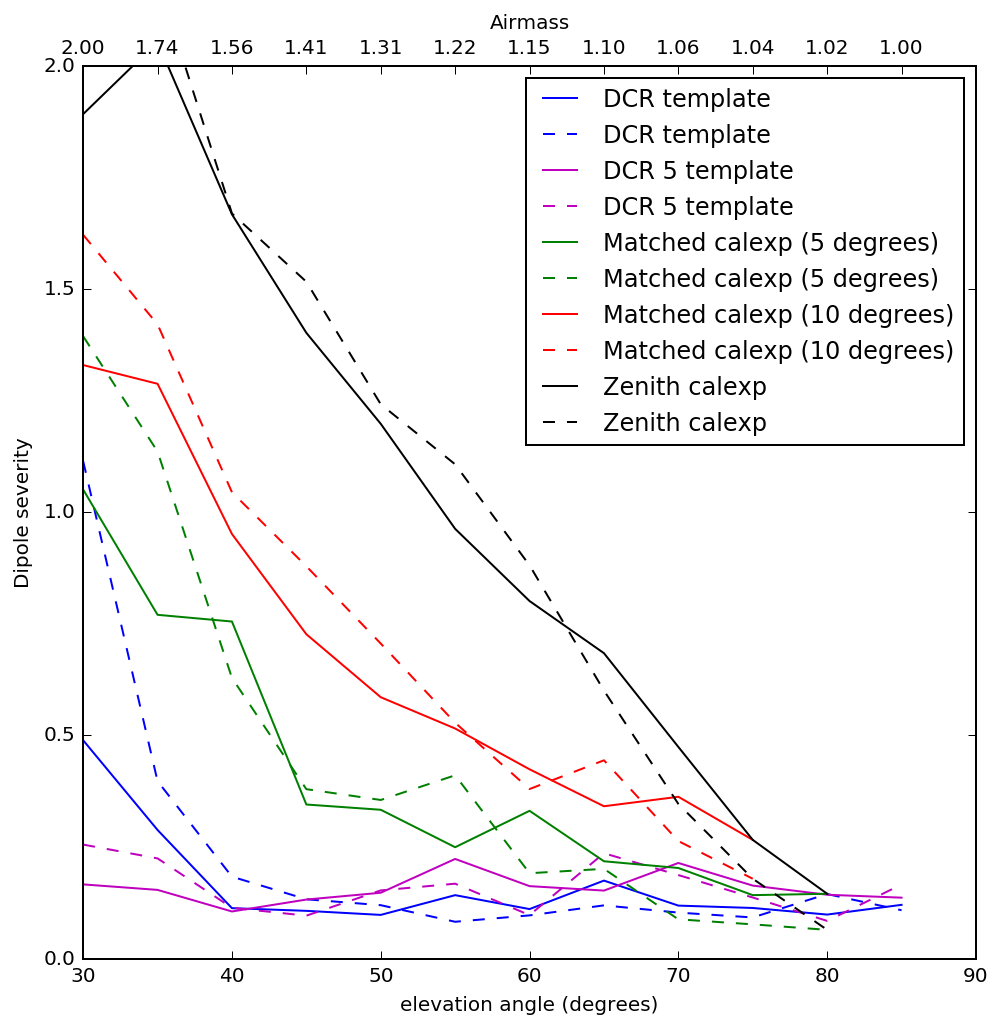

In [108]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling,metric_dcr_falling, color='b')
plot_1.plot(zenith_angle_rising,metric_dcr_rising, color='b', linestyle='--')
# plot_1.plot(zenith_angle_falling,metric_dcr_withpsf_falling, color='g')
# plot_1.plot(zenith_angle_rising,metric_dcr_withpsf_rising, color='g', linestyle='--')
# plot_1.plot(zenith_angle_falling,metric_dcr_fullpsf_falling, color='k')
# plot_1.plot(zenith_angle_rising,metric_dcr_fullpsf_rising, color='k', linestyle='--')
plot_1.plot(zenith_angle_falling[:11],metric_5deg_falling, color='g')
plot_1.plot(zenith_angle_rising[:11],metric_5deg_rising, color='g', linestyle='--')
plot_1.plot(zenith_angle_falling[:10],metric_10deg_falling, color='r')
plot_1.plot(zenith_angle_rising[:10],metric_10deg_rising, color='r', linestyle='--')
plot_1.plot(zenith_angle_falling[:11],metric_zenith_falling, color='k')
plot_1.plot(zenith_angle_rising[:11],metric_zenith_rising, color='k', linestyle='--')
plot_1.legend(["DCR template", "DCR template", 
               "Matched calexp (5 degrees)", "Matched calexp (5 degrees)",
               "Matched calexp (10 degrees)", "Matched calexp (10 degrees)",
               "Zenith calexp", "Zenith calexp"])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Dipole severity')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_rising)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
plot_1.set_ylim([0, 2])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")

In [4]:
def diasrc_metric_sn(repository=".", repository_src=None, obsid_range=None, band='g'):
    """
    Compute statistics on diaSrc tables and return the results.
    @param repository: path to repository with the data. String, defaults to working directory
    @param obsid_range: obsid or range of obsids to process.
    """
    
    saturation = 65000.0
    butler = daf_persistence.Butler(repository)
    if repository_src is not None:
        butler2 = daf_persistence.Butler(repository_src)

    if hasattr(obsid_range, '__iter__'):
        if len(obsid_range) > 2:
            if obsid_range[2] < obsid_range[0]:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in np.arange(obsid_range[0], obsid_range[1], obsid_range[2]))
            else:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in obsid_range)
        else:
            dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                      for obsid in np.arange(obsid_range[0], obsid_range[1]))
    else:
        dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band} for obsid in [obsid_range])

    schema = None
    for _id in dataId:
        dia_src = butler.get("deepDiff_diaSrc", dataId=_id)
        if dia_src.isContiguous() is False:
            dia_src = dia_src.copy(True)
        if schema is None:
            schema = dia_src.getSchema()
            # dipoleKey = schema.find("ip_diffim_DipoleFit_flag_classification").key
            posFluxKey = schema.find("ip_diffim_PsfDipoleFlux_pos_flux").key
            negFluxKey = schema.find("ip_diffim_PsfDipoleFlux_neg_flux").key
            fluxKey = schema.find("base_PsfFlux_flux").key
            sigmaKey = schema.find("base_PsfFlux_fluxSigma").key
            flagKey = schema.find("base_PsfFlux_flag").key
            # flag2Key = schema.find("base_PixelFlags_flag_saturated").key
            # orientationKey = schema.find("ip_diffim_DipoleFit_orientation").key
            # separationKey = schema.find("ip_diffim_DipoleFit_separation").key

#         if repository_src is not None:
#             ref_src = butler2.get("src", dataId=_id)
#             if ref_src.isContiguous() is False:
#                 ref_src = ref_src.copy(True)
#             schema2 = ref_src.getSchema()
#             sigmaKey2 = schema2.find("base_PsfFlux_fluxSigma").key
#             fluxKey2 = schema2.find("base_PsfFlux_flux").key
#             flagKey2 = schema2.find("base_PsfFlux_flag").key
#         else:
#             ref_src = dia_src
#             sigmaKey2 = sigmaKey
#             fluxKey2 = fluxKey
#             flagKey2 = flagKey

#         flux_ref = np.abs(ref_src[fluxKey2])
#         flux_ref = flux_ref[~ref_src[flagKey2]]
#         flux_ref = np.clip(flux_ref, 1.0, saturation)
#         flux_ref = np.sum(flux_ref[np.isfinite(flux_ref)])
        
        flux = np.abs(dia_src[fluxKey])
        flag = dia_src[flagKey]
        sigma = dia_src[sigmaKey]
        
#         flux2 = np.abs(ref_src[fluxKey2])
#         flag2 = ref_src[flagKey2]
#         metric = float(len(flux[~flag]))/len(flux2[~flag2])
        metric = len(flux[~flag])

#         combined_flux = (np.abs(dia_src[posFluxKey]) + np.abs(dia_src[negFluxKey]))
#         metric = np.clip(combined_flux, 1.0, saturation) / np.abs(dia_src[sigmaKey])
#         metric = metric[~dia_src[flagKey]]
#         metric = np.log(1.0 + np.sum(metric[np.isfinite(metric)]) / np.sqrt(flux_ref))
        
        yield (_id['visit'], _id['filter'], metric)

In [10]:
repo = repo_base + "Diffim_dcr"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 24, 2), np.arange(1, 24, 2))
metric_gen = diasrc_metric_sn(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_dcr_rising = []
metric_sn_dcr_rising = []
obs_dcr_falling = []
metric_sn_dcr_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_dcr_rising.append(metric[0])
        metric_sn_dcr_rising.append(metric[2])
    else:
        obs_dcr_falling.append(metric[0])
        metric_sn_dcr_falling.append(metric[2])

(100, 'g', 93)
(102, 'g', 52)
(104, 'g', 47)
(106, 'g', 42)
(108, 'g', 32)
(110, 'g', 35)
(112, 'g', 34)
(114, 'g', 32)
(116, 'g', 31)
(118, 'g', 29)
(120, 'g', 32)
(122, 'g', 25)
(101, 'g', 93)
(103, 'g', 63)
(105, 'g', 58)
(107, 'g', 58)
(109, 'g', 35)
(111, 'g', 43)
(113, 'g', 37)
(115, 'g', 29)
(117, 'g', 31)
(119, 'g', 29)
(121, 'g', 26)
(123, 'g', 28)


In [6]:
repo = repo_base + "Diffim_5deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric_sn(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_5deg_rising = []
metric_sn_5deg_rising = []
obs_5deg_falling = []
metric_sn_5deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_5deg_rising.append(metric[0])
        metric_sn_5deg_rising.append(metric[2])
    else:
        obs_5deg_falling.append(metric[0])
        metric_sn_5deg_falling.append(metric[2])

(100, 'g', 121)
(102, 'g', 49)
(104, 'g', 47)
(106, 'g', 48)
(108, 'g', 39)
(110, 'g', 55)
(112, 'g', 48)
(114, 'g', 33)
(116, 'g', 40)
(118, 'g', 40)
(120, 'g', 48)
(101, 'g', 143)
(103, 'g', 65)
(105, 'g', 47)
(107, 'g', 55)
(109, 'g', 30)
(111, 'g', 53)
(113, 'g', 44)
(115, 'g', 48)
(117, 'g', 40)
(119, 'g', 46)
(121, 'g', 41)


In [7]:
repo = repo_base + "Diffim_10deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 20, 2), np.arange(1, 20, 2))
metric_gen = diasrc_metric_sn(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_10deg_rising = []
metric_sn_10deg_rising = []
obs_10deg_falling = []
metric_sn_10deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_10deg_rising.append(metric[0])
        metric_sn_10deg_rising.append(metric[2])
    else:
        obs_10deg_falling.append(metric[0])
        metric_sn_10deg_falling.append(metric[2])

(100, 'g', 132)
(102, 'g', 78)
(104, 'g', 75)
(106, 'g', 84)
(108, 'g', 69)
(110, 'g', 88)
(112, 'g', 76)
(114, 'g', 57)
(116, 'g', 68)
(118, 'g', 63)
(101, 'g', 155)
(103, 'g', 97)
(105, 'g', 90)
(107, 'g', 74)
(109, 'g', 53)
(111, 'g', 78)
(113, 'g', 82)
(115, 'g', 78)
(117, 'g', 74)
(119, 'g', 73)


In [9]:
repo = repo_base + "Diffim_zen"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric_sn(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_zenith_rising = []
metric_sn_zenith_rising = []
obs_zenith_falling = []
metric_sn_zenith_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_zenith_rising.append(metric[0])
        metric_sn_zenith_rising.append(metric[2])
    else:
        obs_zenith_falling.append(metric[0])
        metric_sn_zenith_falling.append(metric[2])

(100, 'g', 208)
(102, 'g', 218)
(104, 'g', 160)
(106, 'g', 146)
(108, 'g', 131)
(110, 'g', 150)
(112, 'g', 128)
(114, 'g', 89)
(116, 'g', 86)
(118, 'g', 63)
(120, 'g', 48)
(101, 'g', 232)
(103, 'g', 197)
(105, 'g', 182)
(107, 'g', 170)
(109, 'g', 137)
(111, 'g', 150)
(113, 'g', 138)
(115, 'g', 123)
(117, 'g', 89)
(119, 'g', 73)
(121, 'g', 41)


(0, 300)

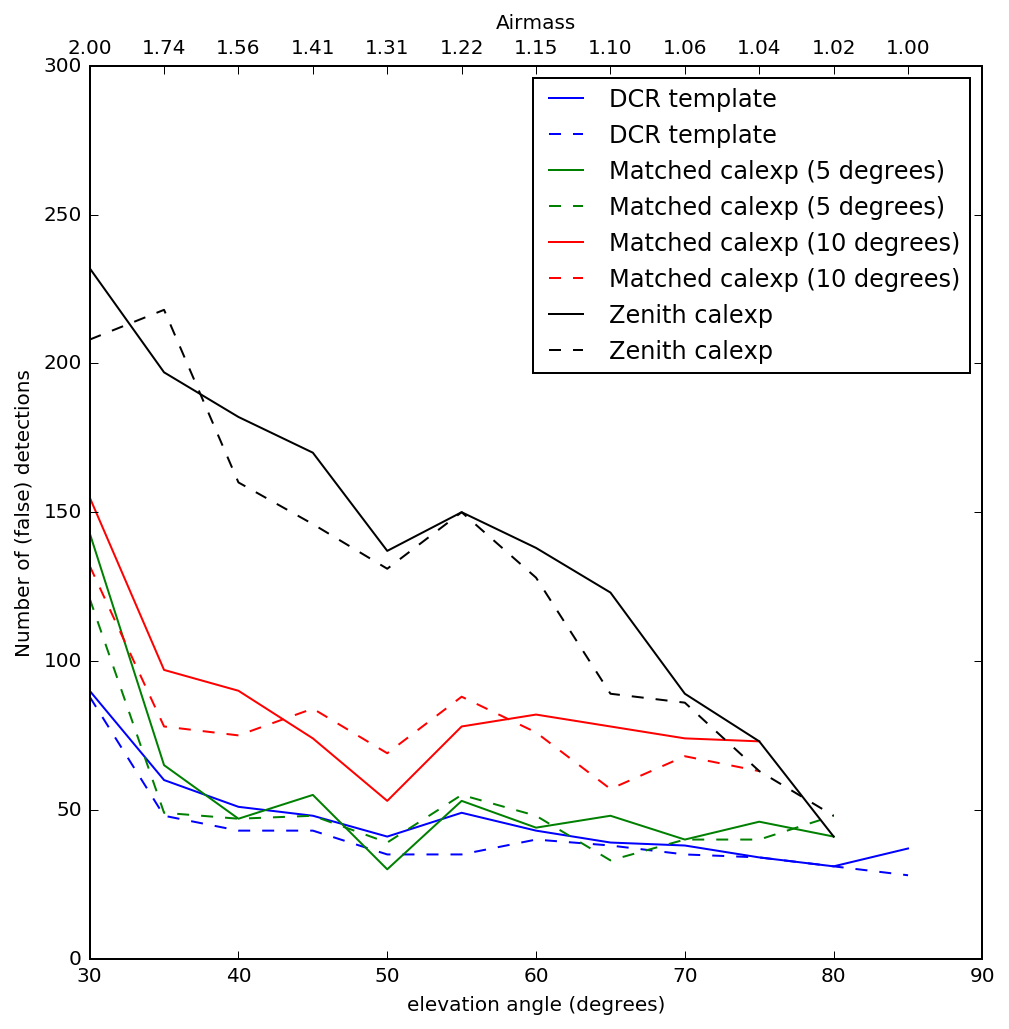

In [16]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling,metric_sn_dcr_falling, color='b')
plot_1.plot(zenith_angle_rising,metric_sn_dcr_rising, color='b', linestyle='--')
plot_1.plot(zenith_angle_falling[:11],metric_sn_5deg_falling, color='g')
plot_1.plot(zenith_angle_rising[:11],metric_sn_5deg_rising, color='g', linestyle='--')
plot_1.plot(zenith_angle_falling[:10],metric_sn_10deg_falling, color='r')
plot_1.plot(zenith_angle_rising[:10],metric_sn_10deg_rising, color='r', linestyle='--')
plot_1.plot(zenith_angle_falling[:11],metric_sn_zenith_falling, color='k')
plot_1.plot(zenith_angle_rising[:11],metric_sn_zenith_rising, color='k', linestyle='--')
plot_1.legend(["DCR template", "DCR template", 
               "Matched calexp (5 degrees)", "Matched calexp (5 degrees)",
               "Matched calexp (10 degrees)", "Matched calexp (10 degrees)",
               "Zenith calexp", "Zenith calexp"])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Number of (false) detections')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_rising)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
plot_1.set_ylim([0, 300])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")

(30, 80)

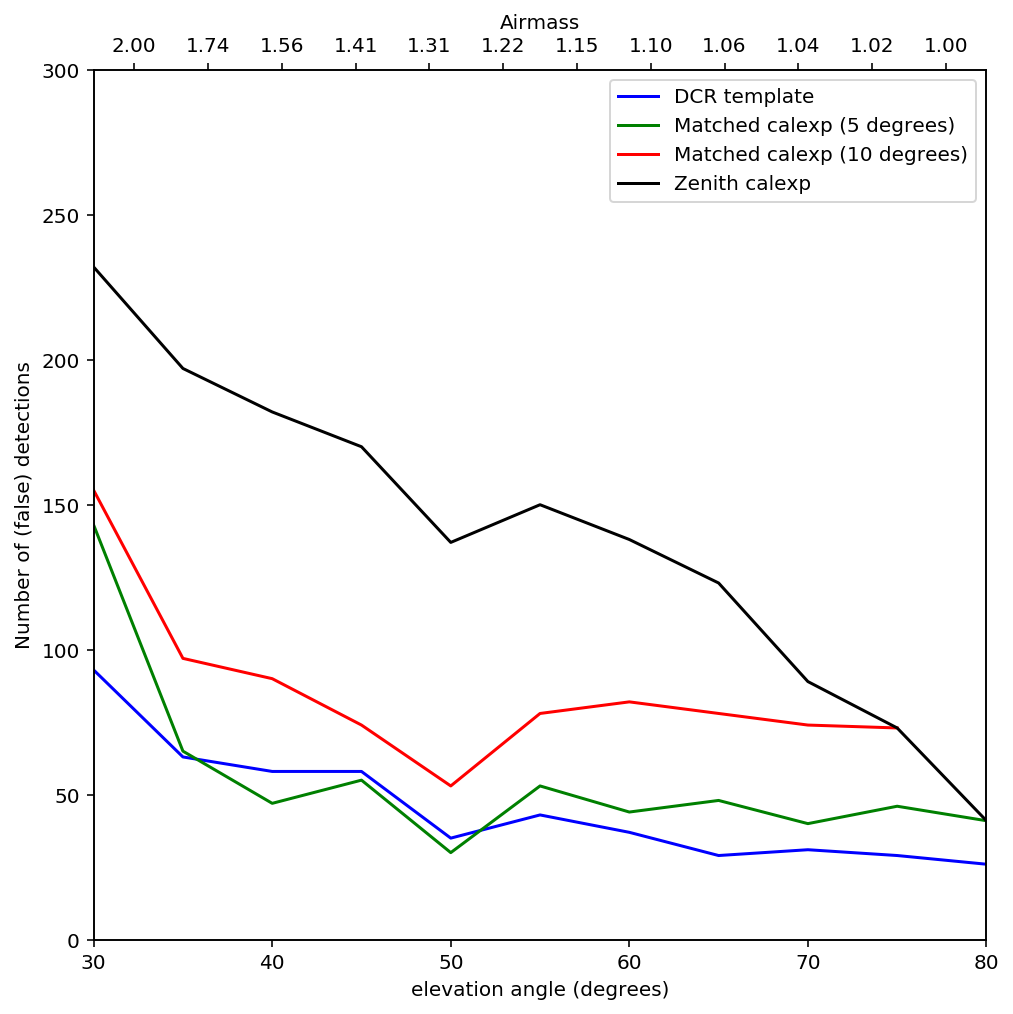

In [11]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling,metric_sn_dcr_falling, color='b')
plot_1.plot(zenith_angle_falling[:11],metric_sn_5deg_falling, color='g')
plot_1.plot(zenith_angle_falling[:10],metric_sn_10deg_falling, color='r')
plot_1.plot(zenith_angle_falling[:11],metric_sn_zenith_falling, color='k')
plot_1.legend(["DCR template",
               "Matched calexp (5 degrees)",
               "Matched calexp (10 degrees)", 
               "Zenith calexp"])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Number of (false) detections')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_rising)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
plot_1.set_ylim([0, 300])
plot_1.set_xlim([30,80])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")

In [17]:
def diasrc_metric_sn2(repository=".", repository_src=None, obsid_range=None, band='g'):
    """
    Compute statistics on diaSrc tables and return the results.
    @param repository: path to repository with the data. String, defaults to working directory
    @param obsid_range: obsid or range of obsids to process.
    """
    
    saturation = 65000.0
    butler = daf_persistence.Butler(repository)
    if repository_src is not None:
        butler2 = daf_persistence.Butler(repository_src)

    if hasattr(obsid_range, '__iter__'):
        if len(obsid_range) > 2:
            if obsid_range[2] < obsid_range[0]:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in np.arange(obsid_range[0], obsid_range[1], obsid_range[2]))
            else:
                dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                          for obsid in obsid_range)
        else:
            dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band}
                      for obsid in np.arange(obsid_range[0], obsid_range[1]))
    else:
        dataId = ({'visit': obsid, 'raft': '2,2', 'sensor': '1,1', 'filter': band} for obsid in [obsid_range])

    schema = None
    for _id in dataId:
        dia_src = butler.get("deepDiff_diaSrc", dataId=_id)
        if dia_src.isContiguous() is False:
            dia_src = dia_src.copy(True)
        if schema is None:
            schema = dia_src.getSchema()
            # dipoleKey = schema.find("ip_diffim_DipoleFit_flag_classification").key
            posFluxKey = schema.find("ip_diffim_PsfDipoleFlux_pos_flux").key
            negFluxKey = schema.find("ip_diffim_PsfDipoleFlux_neg_flux").key
            fluxKey = schema.find("base_PsfFlux_flux").key
            sigmaKey = schema.find("base_PsfFlux_fluxSigma").key
            flagKey = schema.find("base_PsfFlux_flag").key
            # flag2Key = schema.find("base_PixelFlags_flag_saturated").key
            # orientationKey = schema.find("ip_diffim_DipoleFit_orientation").key
            # separationKey = schema.find("ip_diffim_DipoleFit_separation").key

        if repository_src is not None:
            ref_src = butler2.get("src", dataId=_id)
            if ref_src.isContiguous() is False:
                ref_src = ref_src.copy(True)
            schema2 = ref_src.getSchema()
            sigmaKey2 = schema2.find("base_PsfFlux_fluxSigma").key
            fluxKey2 = schema2.find("base_PsfFlux_flux").key
            flagKey2 = schema2.find("base_PsfFlux_flag").key
        else:
            ref_src = dia_src
            sigmaKey2 = sigmaKey
            fluxKey2 = fluxKey
            flagKey2 = flagKey

        flux_ref = np.abs(ref_src[fluxKey2])
        flux_ref = flux_ref[~ref_src[flagKey2]]
        flux_ref = np.clip(flux_ref, 1.0, saturation)
        flux_ref = np.sum(flux_ref[np.isfinite(flux_ref)])
        
        flux = np.abs(dia_src[fluxKey])
        flag = dia_src[flagKey]
        sigma = dia_src[sigmaKey]
        
        flux2 = np.abs(ref_src[fluxKey2])
        flag2 = ref_src[flagKey2]
        metric = float(len(flux[~flag]))/len(flux2[~flag2])
#         metric = len(flux[~flag])

#         combined_flux = (np.abs(dia_src[posFluxKey]) + np.abs(dia_src[negFluxKey]))
#         metric = np.clip(combined_flux, 1.0, saturation) / np.abs(dia_src[sigmaKey])
#         metric = metric[~dia_src[flagKey]]
#         metric = np.log(1.0 + np.sum(metric[np.isfinite(metric)]) / np.sqrt(flux_ref))
        
        yield (_id['visit'], _id['filter'], metric)

In [18]:
repo = repo_base + "Diffim_dcr"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 24, 2), np.arange(1, 24, 2))
metric_gen = diasrc_metric_sn2(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_dcr_rising = []
metric_sn2_dcr_rising = []
obs_dcr_falling = []
metric_sn2_dcr_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_dcr_rising.append(metric[0])
        metric_sn2_dcr_rising.append(metric[2])
    else:
        obs_dcr_falling.append(metric[0])
        metric_sn2_dcr_falling.append(metric[2])

(100, 'g', 0.17245817245817247)
(102, 'g', 0.1332518337408313)
(104, 'g', 0.10913404507710557)
(106, 'g', 0.08963911525029103)
(108, 'g', 0.08626560726447219)
(110, 'g', 0.08491620111731843)
(112, 'g', 0.06981981981981981)
(114, 'g', 0.06695938529088913)
(116, 'g', 0.060066740823136816)
(118, 'g', 0.0581140350877193)
(120, 'g', 0.04415011037527594)
(122, 'g', 0.05714285714285714)
(101, 'g', 0.16279069767441862)
(103, 'g', 0.12484848484848485)
(105, 'g', 0.1278648974668275)
(107, 'g', 0.09919261822376009)
(109, 'g', 0.07753705815279362)
(111, 'g', 0.06186726659167604)
(113, 'g', 0.059684684684684686)
(115, 'g', 0.05)
(117, 'g', 0.04630650496141125)
(119, 'g', 0.04400440044004401)
(121, 'g', 0.04480874316939891)
(123, 'g', 0.05131004366812227)


In [19]:
repo = repo_base + "Diffim_new_10deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 20, 2), np.arange(1, 20, 2))
metric_gen = diasrc_metric_sn2(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_10deg_rising = []
metric_sn2_10deg_rising = []
obs_10deg_falling = []
metric_sn2_10deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_10deg_rising.append(metric[0])
        metric_sn2_10deg_rising.append(metric[2])
    else:
        obs_10deg_falling.append(metric[0])
        metric_sn2_10deg_falling.append(metric[2])

(100, 'g', 0.24066924066924067)
(102, 'g', 0.23471882640586797)
(104, 'g', 0.19217081850533807)
(106, 'g', 0.18277066356228172)
(108, 'g', 0.15891032917139614)
(110, 'g', 0.15195530726256984)
(112, 'g', 0.16103603603603603)
(114, 'g', 0.1350164654226125)
(116, 'g', 0.13236929922135707)
(118, 'g', 0.14035087719298245)
(101, 'g', 0.27002583979328165)
(103, 'g', 0.22666666666666666)
(105, 'g', 0.20627261761158022)
(107, 'g', 0.19377162629757785)
(109, 'g', 0.18814139110604333)
(111, 'g', 0.11361079865016872)
(113, 'g', 0.13626126126126126)
(115, 'g', 0.14888888888888888)
(117, 'g', 0.1378169790518192)
(119, 'g', 0.1254125412541254)


In [20]:
repo = repo_base + "Diffim_new_5deg"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric_sn2(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_5deg_rising = []
metric_sn2_5deg_rising = []
obs_5deg_falling = []
metric_sn2_5deg_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_5deg_rising.append(metric[0])
        metric_sn2_5deg_rising.append(metric[2])
    else:
        obs_5deg_falling.append(metric[0])
        metric_sn2_5deg_falling.append(metric[2])

(100, 'g', 0.22522522522522523)
(102, 'g', 0.16381418092909536)
(104, 'g', 0.14116251482799524)
(106, 'g', 0.10710128055878929)
(108, 'g', 0.1021566401816118)
(110, 'g', 0.09162011173184358)
(112, 'g', 0.10923423423423423)
(114, 'g', 0.07793633369923161)
(116, 'g', 0.060066740823136816)
(118, 'g', 0.09320175438596491)
(120, 'g', 0.0640176600441501)
(101, 'g', 0.2351421188630491)
(103, 'g', 0.17454545454545456)
(105, 'g', 0.15319662243667068)
(107, 'g', 0.12110726643598616)
(109, 'g', 0.12314709236031927)
(111, 'g', 0.08211473565804274)
(113, 'g', 0.07882882882882883)
(115, 'g', 0.08888888888888889)
(117, 'g', 0.08269018743109151)
(119, 'g', 0.0704070407040704)
(121, 'g', 0.06557377049180328)


In [21]:
repo = repo_base + "Diffim_new_zenith"
repo_src = repo_base + "output_data"
base_range = np.append(np.arange(0, 22, 2), np.arange(1, 22, 2))
metric_gen = diasrc_metric_sn2(repository=repo, repository_src=repo_src, obsid_range=base_range + 100, band='g')
obs_zenith_rising = []
metric_sn2_zenith_rising = []
obs_zenith_falling = []
metric_sn2_zenith_falling = []
for metric in metric_gen:
    print(metric)
    if metric[0] % 2 == 0:
        obs_zenith_rising.append(metric[0])
        metric_sn2_zenith_rising.append(metric[2])
    else:
        obs_zenith_falling.append(metric[0])
        metric_sn2_zenith_falling.append(metric[2])

(100, 'g', 0.3204633204633205)
(102, 'g', 0.32396088019559904)
(104, 'g', 0.32147093712930014)
(106, 'g', 0.2991850989522701)
(108, 'g', 0.28944381384790013)
(110, 'g', 0.26033519553072626)
(112, 'g', 0.25675675675675674)
(114, 'g', 0.20417124039517015)
(116, 'g', 0.1757508342602892)
(118, 'g', 0.14035087719298245)
(120, 'g', 0.0640176600441501)
(101, 'g', 0.31912144702842377)
(103, 'g', 0.3236363636363636)
(105, 'g', 0.32689987937273823)
(107, 'g', 0.30103806228373703)
(109, 'g', 0.2805017103762828)
(111, 'g', 0.21822272215973004)
(113, 'g', 0.24887387387387389)
(115, 'g', 0.2111111111111111)
(117, 'g', 0.185226019845645)
(119, 'g', 0.1254125412541254)
(121, 'g', 0.06557377049180328)


(30, 80)

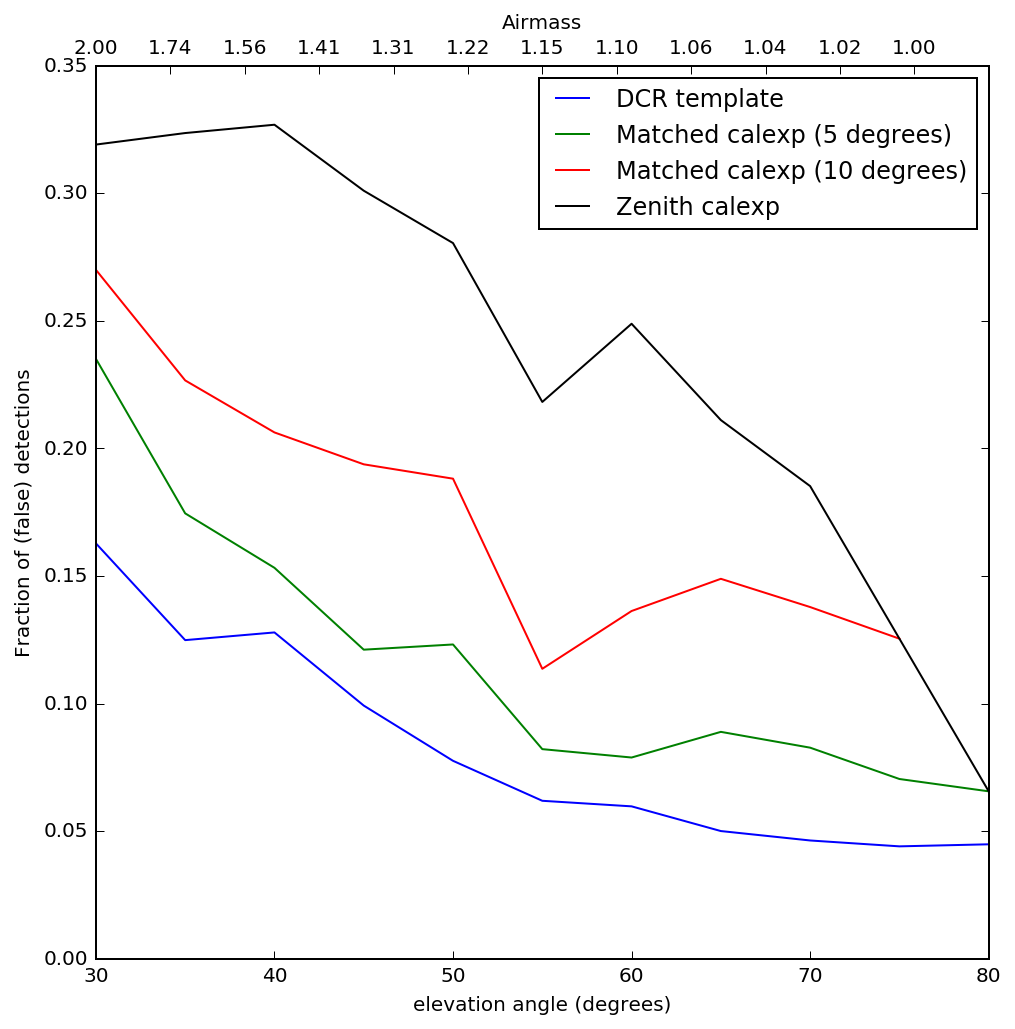

In [22]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling,metric_sn2_dcr_falling, color='b')
plot_1.plot(zenith_angle_falling[:11],metric_sn2_5deg_falling, color='g')
plot_1.plot(zenith_angle_falling[:10],metric_sn2_10deg_falling, color='r')
plot_1.plot(zenith_angle_falling[:11],metric_sn2_zenith_falling, color='k')
plot_1.legend(["DCR template",
               "Matched calexp (5 degrees)", 
               "Matched calexp (10 degrees)", 
               "Zenith calexp"])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Fraction of (false) detections')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_rising)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
plot_1.set_ylim([0, .35])
plot_1.set_xlim([30, 80])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")

(0, 0.35)

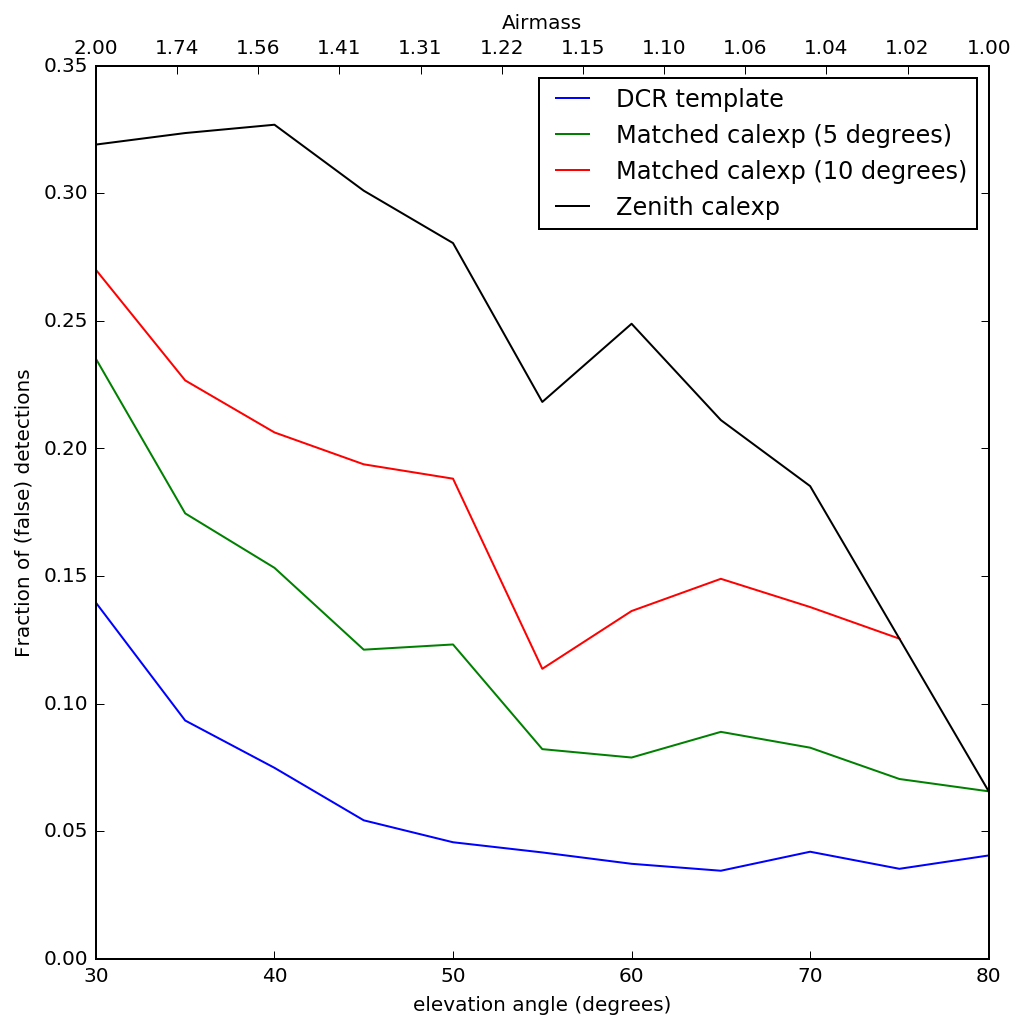

In [9]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling[:11],metric_sn2_dcr_falling[:11], color='b')
plot_1.plot(zenith_angle_falling[:11],metric_sn2_5deg_falling, color='g')
plot_1.plot(zenith_angle_falling[:10],metric_sn2_10deg_falling, color='r')
plot_1.plot(zenith_angle_falling[:11],metric_sn2_zenith_falling, color='k')
plot_1.legend(["DCR template", 
               "Matched calexp (5 degrees)",
               "Matched calexp (10 degrees)",
               "Zenith calexp"])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Fraction of (false) detections')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_rising)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
plot_1.set_ylim([0, .35])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")

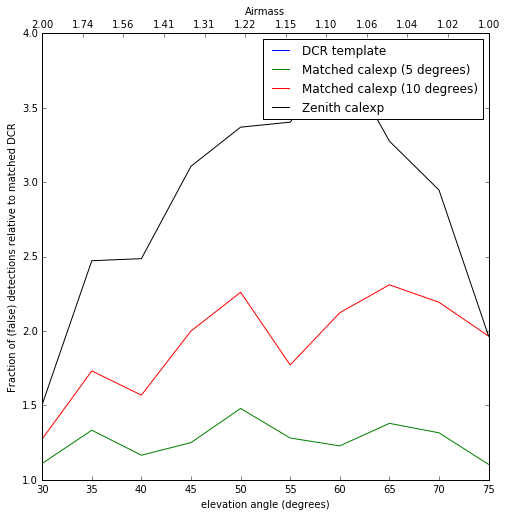

In [93]:
fig=plt.figure(figsize=(8,8))
plot_1  = fig.add_subplot(1,1,1)
plot_1.plot(zenith_angle_falling[:10],[metric_sn2_dcr_falling[i]/metric_sn2_dcr_falling[i] for i in range(10)], color='b')
plot_1.plot(zenith_angle_falling[:10],[metric_sn2_5deg_falling[i]/metric_sn2_dcr_falling[i] for i in range(10)], color='g')
plot_1.plot(zenith_angle_falling[:10],[metric_sn2_10deg_falling[i]/metric_sn2_dcr_falling[i] for i in range(10)], color='r')
plot_1.plot(zenith_angle_falling[:10],[metric_sn2_zenith_falling[i]/metric_sn2_dcr_falling[i] for i in range(10)], color='k')
plot_1.legend(["DCR template",
               "Matched calexp (5 degrees)",
               "Matched calexp (10 degrees)",
               "Zenith calexp",])
lx = plot_1.set_xlabel('elevation angle (degrees)')
ly = plot_1.set_ylabel('Fraction of (false) detections relative to matched DCR')
ax2 = plot_1.twiny()
ax2.set_xlim(plot_1.get_xlim())
ax2.set_xticks(zenith_angle_falling)
ax2.set_xticklabels(["%1.2f" % (1.0 / np.sin(angle * np.pi / 180.0)) for angle in zenith_angle_rising])
ax2.set_xlabel("Airmass")
# plot_1.set_ylim([0, 4])
# fig.savefig("_static/Dipole_severity_metric_plot_" + repo_version + ".png")